## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-03-15 10:30:18.726215


{1: 24.0,
 5: 25.3,
 10: 26.1,
 20: 27.0,
 30: 28.3,
 40: 30.1,
 50: 31.9,
 60: 33.7,
 70: 35.7,
 80: 38.2,
 90: 41.6,
 95: 44.5,
 99: 50.0}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-03-27 14:14:57.057497


{1: 7.8,
 5: 8.0,
 10: 8.1,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.8,
 70: 8.9,
 80: 9.1,
 90: 9.3,
 95: 9.6,
 99: 10.0}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-03-18 09:27:37.133234


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.norm(18.2, 19.4),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 47657.02it/s]


{1: 0.00072,
 5: 0.00105,
 10: 0.00133,
 20: 0.00178,
 30: 0.00221,
 40: 0.00264,
 50: 0.00317,
 60: 0.00382,
 70: 0.00512,
 80: 0.00803,
 90: 0.01194,
 95: 0.01474,
 99: 0.02071}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.072%',
 5: '0.105%',
 10: '0.133%',
 20: '0.178%',
 30: '0.221%',
 40: '0.264%',
 50: '0.317%',
 60: '0.382%',
 70: '0.512%',
 80: '0.803%',
 90: '1.194%',
 95: '1.474%',
 99: '2.071%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '18.2 billion',
 5: '26.2 billion',
 10: '33.3 billion',
 20: '44.8 billion',
 30: '55.4 billion',
 40: '66.3 billion',
 50: '79.7 billion',
 60: '96.0 billion',
 70: '128.4 billion',
 80: '201.4 billion',
 90: '300.0 billion',
 95: '370.7 billion',
 99: '518.5 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 899601.92it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00025,
 60: 0.00037,
 70: 0.00056,
 80: 0.00089,
 90: 0.00179,
 95: 0.003,
 99: 0.0081}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.025%',
 60: '0.037%',
 70: '0.056%',
 80: '0.089%',
 90: '0.179%',
 95: '0.3%',
 99: '0.81%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.2 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.4 billion',
 60: '9.2 billion',
 70: '14.1 billion',
 80: '22.3 billion',
 90: '44.9 billion',
 95: '75.1 billion',
 99: '202.3 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 34.9 log FLOP (~79.4 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 3.7 year to a max of 0.119677% of GDP (initially ~29.8 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 34.9 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 9.2 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
2026 - TAI takes 34.6 logFLOP which costs 15.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 34.2 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 9.4 (buys 28.8 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 33.9 logFLOP which costs 14

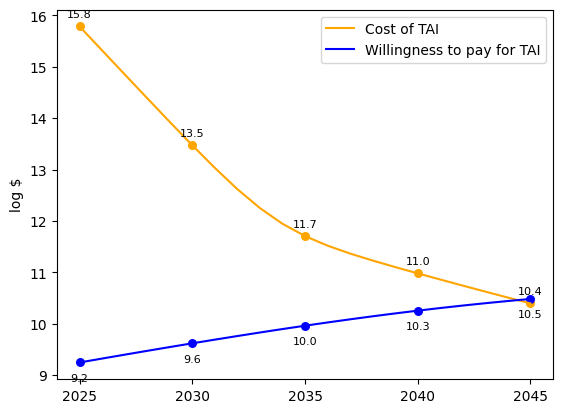



## SAMPLE RUN 2 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~240.9 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~863.2 million).
* This doubles every 1.6 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.007x per year.
---
2025 - TAI takes 27.8 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 27.6 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total de

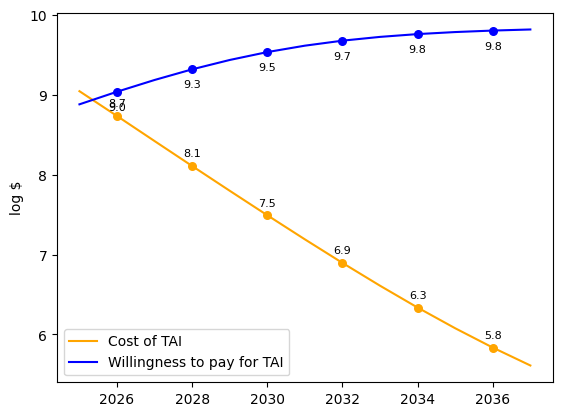



## SAMPLE RUN 3 ##

In this simulation:
* It takes 41.8 log FLOP (~631.0 million decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~253.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~195.4 million).
* This doubles every 22.4 year to a max of 0.038083% of GDP (initially ~9.5 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 41.8 logFLOP which costs 22.9 log 2025$USD to buy vs. WTP at 8.3 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 41.4 logFLOP which costs 22.3 log 2025$USD to buy vs. WTP at 8.3 (buys 27.4 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 41.0 logFLOP which costs 21.8 log 2025$USD to buy vs. WTP at 8.3 (buys 27.5 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 40.6 logFLOP whic

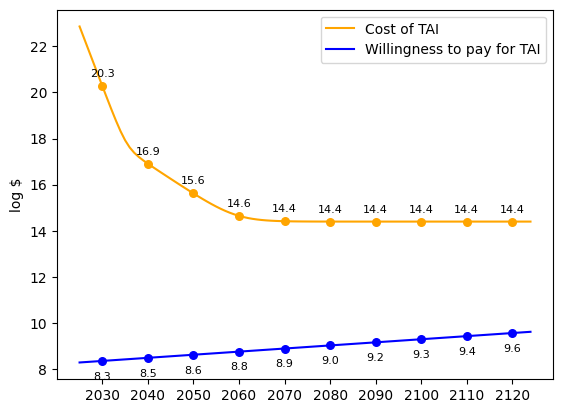



## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.77it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 562.99it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2032',
 '15%: 2034',
 '20%: 2035',
 '25%: 2037',
 '35%: 2040',
 '50%: 2047',
 '60%: 2055',
 '75%: 2091',
 '80%: >2125',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 7 years from now',
 '15%: 9 years from now',
 '20%: 10 years from now',
 '25%: 12 years from now',
 '35%: 15 years from now',
 '50%: 22 years from now',
 '60%: 30 years from now',
 '75%: 66 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 40 years from now)


## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2026-2027: 0.3%
2028-2030: 4.7%
2030-2034: 14.7%
2035-2039: 16.3%
2040-2049: 20.0%
2050-2059: 10.8%
2060-2069: 5.6%
2070-2079: 3.4%
2080-2089: 1.5%
2090-2099: 0.7%
2100-2109: 0.5%
2110-2119: 0.4



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~25.9 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.4 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.6 trillion) - 13.5 (~28.2 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.0 trillion) - 13.5 (~29.0 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.4 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.3 trillion) 80% CI 13.4 (~27.9 trillion) - 13.5 (~30.7 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.3 trillion) - 13.5 (~31.6 trillion)
Year: 2034 - GDP log 2024$USD 13.

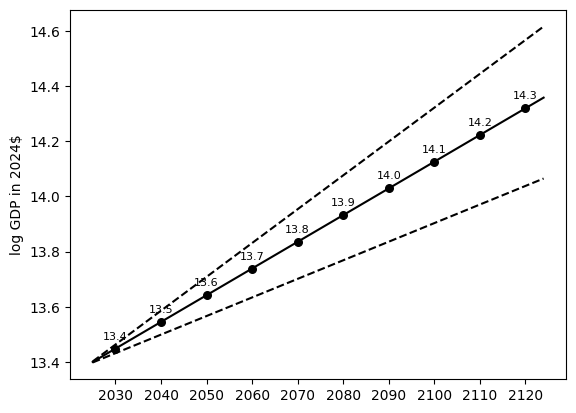

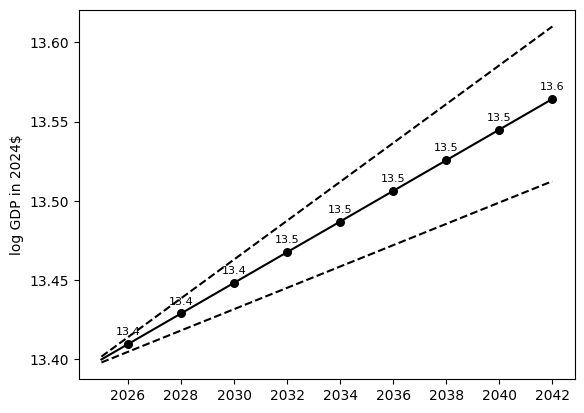



## Willingness to Pay Over Time ##
Year: 2025 - willingness log 2024$USD per year 8.7 (~464.1 million) 80% CI 8.3 (~193.4 million) - 9.1 (~1.2 billion)
Year: 2026 - willingness log 2024$USD per year 8.8 (~578.2 million) 80% CI 8.5 (~291.2 million) - 9.1 (~1.3 billion)
Year: 2027 - willingness log 2024$USD per year 8.9 (~717.7 million) 80% CI 8.6 (~435.2 million) - 9.2 (~1.5 billion)
Year: 2028 - willingness log 2024$USD per year 8.9 (~886.7 million) 80% CI 8.8 (~643.6 million) - 9.2 (~1.8 billion)
Year: 2029 - willingness log 2024$USD per year 9.0 (~1.1 billion) 80% CI 9.0 (~937.8 million) - 9.3 (~2.0 billion)
Year: 2030 - willingness log 2024$USD per year 9.1 (~1.3 billion) 80% CI 9.1 (~1.3 billion) - 9.4 (~2.3 billion)
Year: 2031 - willingness log 2024$USD per year 9.2 (~1.6 billion) 80% CI 9.3 (~1.9 billion) - 9.4 (~2.6 billion)
Year: 2032 - willingness log 2024$USD per year 9.3 (~1.9 billion) 80% CI 9.4 (~2.5 billion) - 9.5 (~2.9 billion)
Year: 2033 - willingness log 2024$USD per

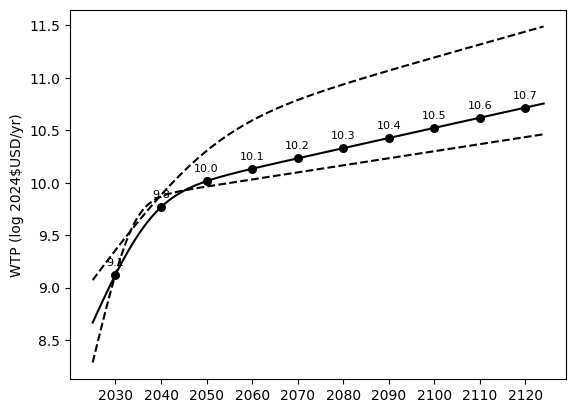

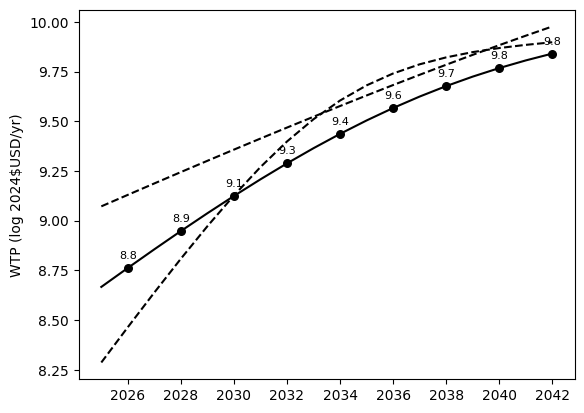



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 31.8 (~63.1 nonillion) 80% CI 27.1 (~1.3 octillion) - 37.8 (~63.1 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.5 (~32.1 nonillion) 80% CI 26.8 (~656.1 septillion) - 37.6 (~38.3 thousand decillion)
Year: 2027 - logFLOP needed for TAI 31.2 (~16.3 nonillion) 80% CI 26.5 (~341.5 septillion) - 37.4 (~23.2 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.9 (~8.5 nonillion) 80% CI 26.3 (~180.7 septillion) - 37.1 (~14.1 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.7 (~4.5 nonillion) 80% CI 26.0 (~98.5 septillion) - 36.9 (~8.6 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.4 (~2.6 nonillion) 80% CI 25.8 (~56.5 septillion) - 36.7 (~5.2 thousand decillion)
Year: 2031 - logFLOP needed for TAI 30.2 (~1.6 nonillion) 80% CI 25.5 (~35.0 septillion) - 36.5 (~3.2 thousand decillion)
Year: 2032 - logFLOP needed for TAI 30.0 (~1.1 nonillion) 80% CI 25.4 

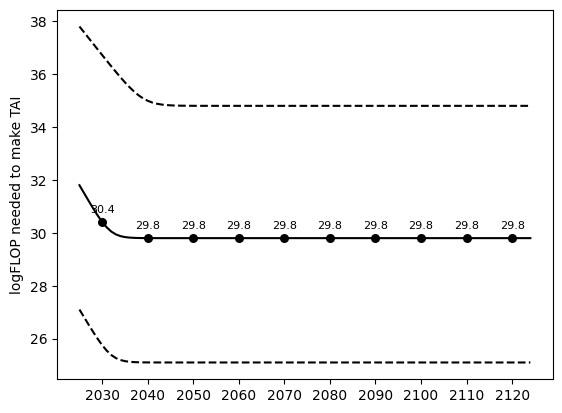

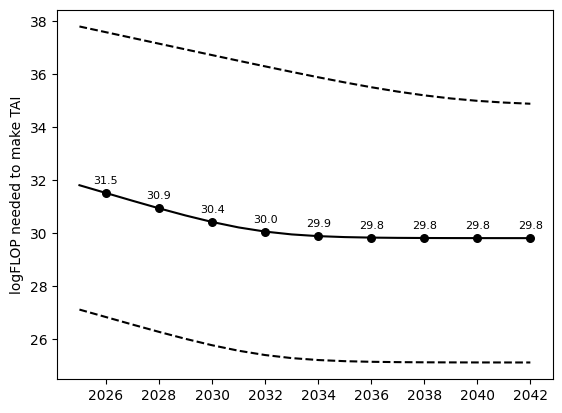



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.8 (~6.3 quintillion) 80% CI 18.5 (~3.0 quintillion) - 19.1 (~12.7 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.9 (~8.3 quintillion) 80% CI 18.6 (~4.1 quintillion) - 19.2 (~16.4 quintillion)
Year: 2027 - logFLOP per 2024$1USD 19.0 (~10.9 quintillion) 80% CI 18.7 (~5.6 quintillion) - 19.3 (~21.1 quintillion)
Year: 2028 - logFLOP per 2024$1USD 19.2 (~14.5 quintillion) 80% CI 18.9 (~7.6 quintillion) - 19.4 (~27.2 quintillion)
Year: 2029 - logFLOP per 2024$1USD 19.3 (~19.1 quintillion) 80% CI 19.0 (~10.4 quintillion) - 19.5 (~35.1 quintillion)
Year: 2030 - logFLOP per 2024$1USD 19.4 (~25.2 quintillion) 80% CI 19.2 (~14.2 quintillion) - 19.7 (~45.3 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.5 (~33.4 quintillion) 80% CI 19.3 (~19.4 quintillion) - 19.8 (~58.4 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.6 (~44.1 quintillion) 80% CI 19.4 (~26.4 quintillion) - 19.9 (~75.2 quintillion)
Year: 

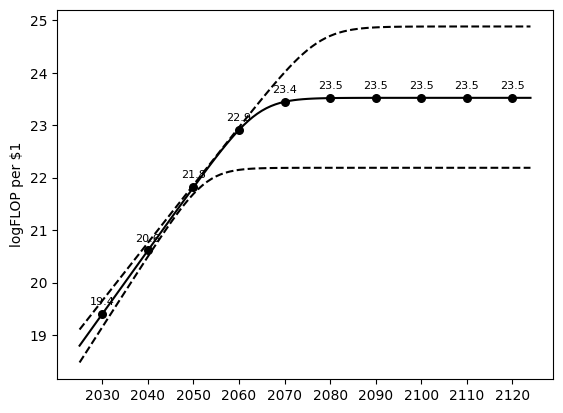

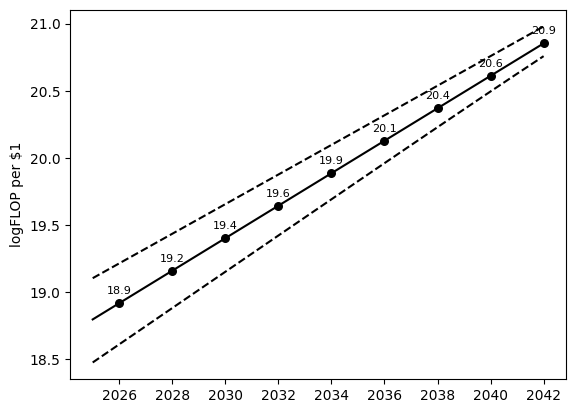



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

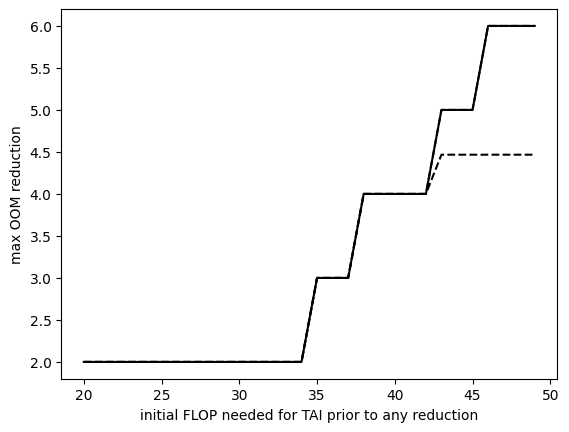



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 21 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 22 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 23 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 24 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 25 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 26 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 27 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 28 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 29 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 30 -> algo doubling rate 1.47yrs (80% CI: 2.11 to 2.11)
TAI log FLOP 31 -> algo doubling rate 1.0yrs (80% CI: 1.61 to 1.61)
TAI log FLOP 32 -> algo doubling rate 1.0yrs (80% CI: 1.11 to 1.11)
TAI log FLOP 33 -> algo doubling rate 1.0yrs (80% CI

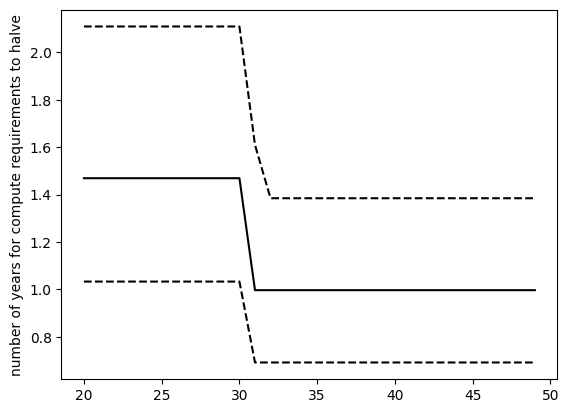



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 13.0 log 2024$USD to buy TAI (~10.1 trillion) 80% CI 8.6 (~420.1 million) - 18.7 (~5.0 quintillion)
Year: 2026 - 12.6 log 2024$USD to buy TAI (~3.9 trillion) 80% CI 8.2 (~160.4 million) - 18.4 (~2.3 quintillion)
Year: 2027 - 12.2 log 2024$USD to buy TAI (~1.5 trillion) 80% CI 7.8 (~61.2 million) - 18.0 (~1.1 quintillion)
Year: 2028 - 11.8 log 2024$USD to buy TAI (~585.1 billion) 80% CI 7.4 (~23.7 million) - 17.7 (~518.1 quadrillion)
Year: 2029 - 11.4 log 2024$USD to buy TAI (~237.4 billion) 80% CI 7.0 (~9.5 million) - 17.4 (~244.3 quadrillion)
Year: 2030 - 11.0 log 2024$USD to buy TAI (~102.2 billion) 80% CI 6.6 (~4.0 million) - 17.1 (~115.4 quadrillion)
Year: 2031 - 10.7 log 2024$USD to buy TAI (~48.1 billion) 80% CI 6.3 (~1.8 million) - 16.7 (~54.7 quadrillion)
Year: 2032 - 10.4 log 2024$USD to buy TAI (~25.3 billion) 80% CI 6.0 (~910.5 thousand) - 16.4 (~26.1 quadrillion)
Year: 2

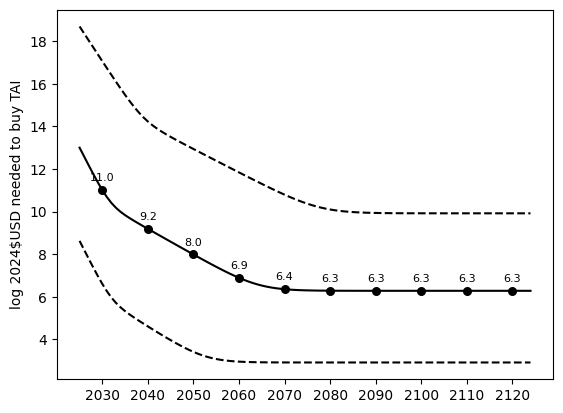

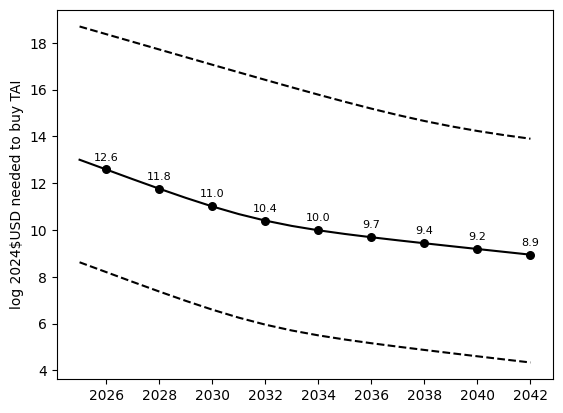



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.5 (~2.9 octillion) 80% CI 26.8 (~579.4 septillion) - 28.2 (~15.0 octillion)
Year: 2026 - max log FLOP 27.7 (~4.8 octillion) 80% CI 27.1 (~1.2 octillion) - 28.3 (~22.1 octillion)
Year: 2027 - max log FLOP 27.9 (~7.9 octillion) 80% CI 27.4 (~2.4 octillion) - 28.5 (~32.5 octillion)
Year: 2028 - max log FLOP 28.1 (~12.8 octillion) 80% CI 27.7 (~4.9 octillion) - 28.7 (~47.8 octillion)
Year: 2029 - max log FLOP 28.3 (~20.8 octillion) 80% CI 28.0 (~9.8 octillion) - 28.8 (~70.3 octillion)
Year: 2030 - max log FLOP 28.5 (~33.6 octillion) 80% CI 28.3 (~19.0 octillion) - 29.0 (~103.1 octillion)
Year: 2031 - max log FLOP 28.7 (~53.8 octillion) 80% CI 28.6 (~36.0 octillion) - 29.2 (~151.1 octillion)
Year: 2032 - max log FLOP 28.9 (~85.6 octillion) 80% CI 28.8 (~66.1 octillion) - 29.3 (~221.2 octillion)
Year: 2033 - max log FLOP 29.1 (~134.8 octillion) 80% CI 29.1 (~116.8 octillion) - 29.5 (~323.3 octillion)
Year: 2034 - max log FLOP 29.3

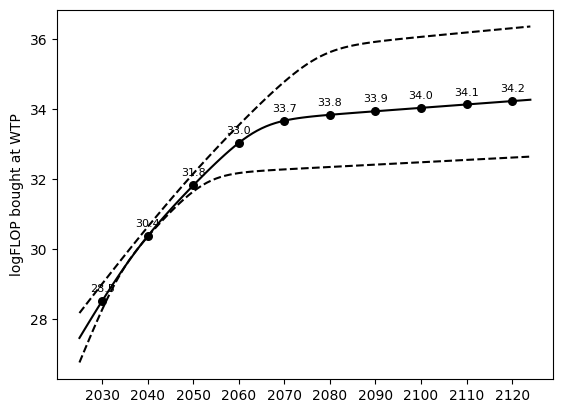

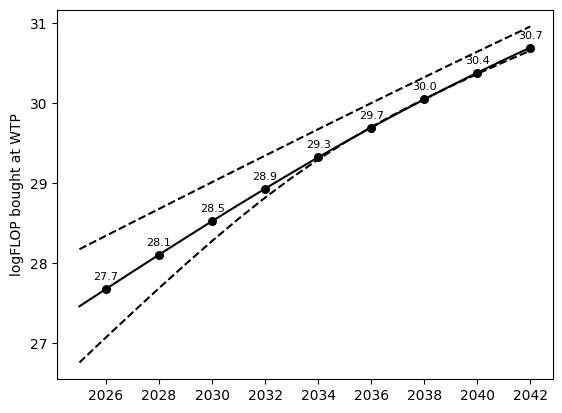



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.5 (~2.9 octillion) 80% CI 26.8 (~579.4 septillion) - 28.2 (~15.0 octillion)
Year: 2026 - max log effective 2024-FLOP 28.0 (~9.4 octillion) 80% CI 27.3 (~1.9 octillion) - 28.8 (~60.1 octillion)
Year: 2027 - max log effective 2024-FLOP 28.5 (~30.4 octillion) 80% CI 27.8 (~6.4 octillion) - 29.4 (~239.9 octillion)
Year: 2028 - max log effective 2024-FLOP 29.0 (~95.6 octillion) 80% CI 28.3 (~21.1 octillion) - 30.0 (~949.0 octillion)
Year: 2029 - max log effective 2024-FLOP 29.5 (~289.6 octillion) 80% CI 28.8 (~67.3 octillion) - 30.6 (~3.7 nonillion)
Year: 2030 - max log effective 2024-FLOP 29.9 (~822.0 octillion) 80% CI 29.3 (~206.9 octillion) - 31.1 (~13.5 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.3 (~2.1 nonillion) 80% CI 29.8 (~604.8 octillion) - 31.6 (~43.9 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.7 (~4.8 nonillion) 80% CI 30.

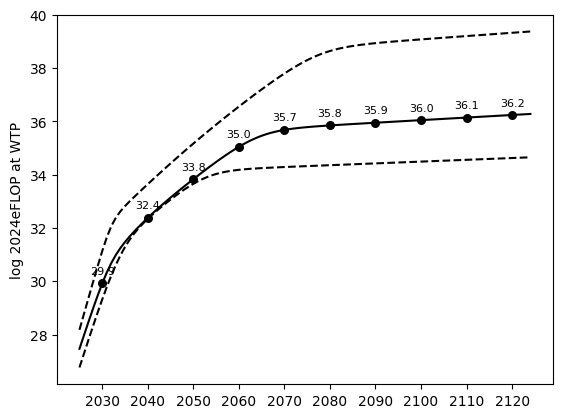

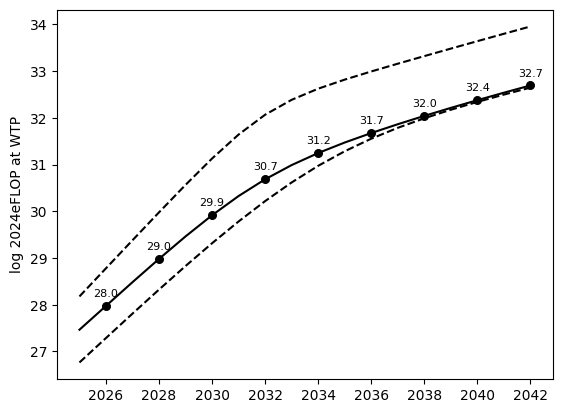


## TAI FLOP SIZE ##
{1: 24.1,
 5: 25.5,
 10: 26.2,
 20: 27.1,
 30: 28.5,
 40: 30.2,
 50: 31.8,
 60: 33.6,
 70: 35.32999999999999,
 80: 37.8,
 90: 41.2,
 95: 44.1,
 99: 48.8}


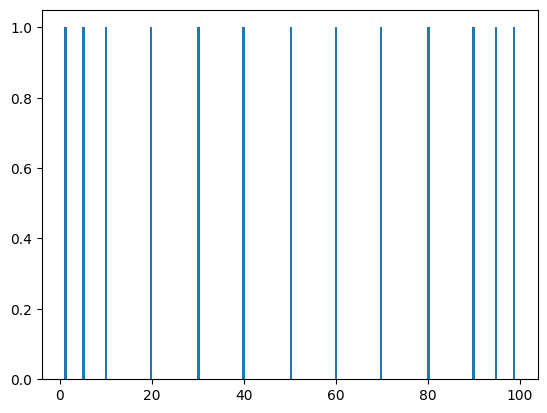



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.228451980417718,
 5: 3.225956162378142,
 10: 3.705989294362926,
 20: 4.466918338708579,
 30: 5.067507715825174,
 40: 5.798522149034526,
 50: 6.5327933938966325,
 60: 7.374648093962761,
 70: 8.371561419408046,
 80: 9.76934976615981,
 90: 12.031377791996855,
 95: 14.363894766127421,
 99: 20.129741345233203}


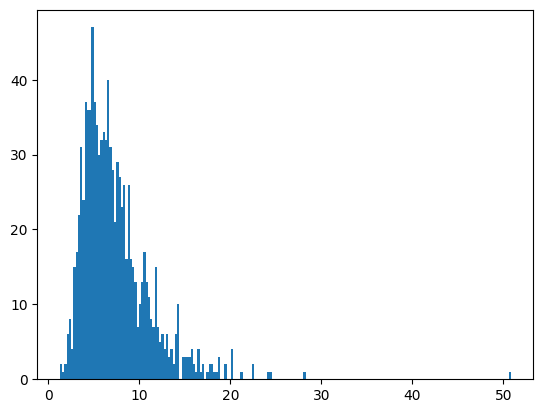



## MIN ALGO DOUBLING RATE ##
{1: 0.35735497882459455,
 5: 0.4748745544286004,
 10: 0.5623392658066462,
 20: 0.6914409584847521,
 30: 0.7995643989332969,
 40: 0.8986575021420472,
 50: 0.9965945679020813,
 60: 1.0977331898815736,
 70: 1.2175260182344283,
 80: 1.3845705110231081,
 90: 1.6595960022594731,
 95: 1.9174540091068455,
 99: 2.629536021994903}


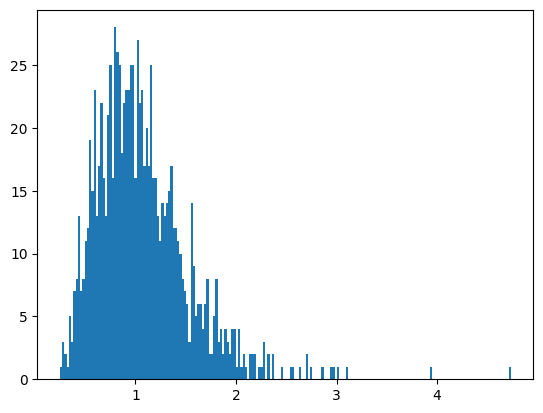



## MAX ALGO DOUBLING RATE ##
{1: 0.5634506741002904,
 5: 0.705303475629755,
 10: 0.8588432487483458,
 20: 1.0328592229712148,
 30: 1.1712952991041419,
 40: 1.3209176725822551,
 50: 1.469096500551183,
 60: 1.6126355958275105,
 70: 1.8263232701989058,
 80: 2.109430179804167,
 90: 2.53371968080586,
 95: 3.073148775199596,
 99: 3.9785610747731726}


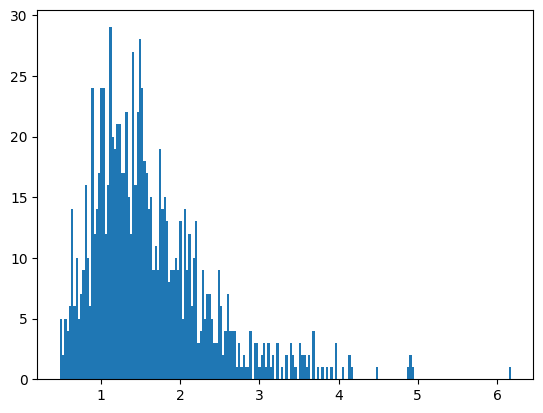



## INITIAL FLOP PER DOLLAR ##
{1: 17.976226620960887,
 5: 18.18576986680283,
 10: 18.307289907120868,
 20: 18.476715926231105,
 30: 18.597919809612886,
 40: 18.70833491338453,
 50: 18.7972978871854,
 60: 18.897663548273076,
 70: 18.993582698866234,
 80: 19.1044936135382,
 90: 19.256049559669492,
 95: 19.382062863870033,
 99: 19.61264953638124}


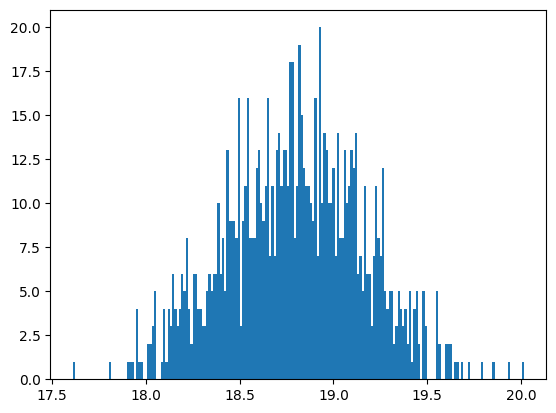



## FLOP HALVING RATE ##
{1: 1.7939505841281131,
 5: 1.992959601588672,
 10: 2.1036326459857713,
 20: 2.227108401422531,
 30: 2.324428408596374,
 40: 2.4099004071456456,
 50: 2.4880591927378712,
 60: 2.554074711187733,
 70: 2.6381246720748965,
 80: 2.7297922589828363,
 90: 2.8574852448879535,
 95: 2.9991381683763905,
 99: 3.1734636999097128}


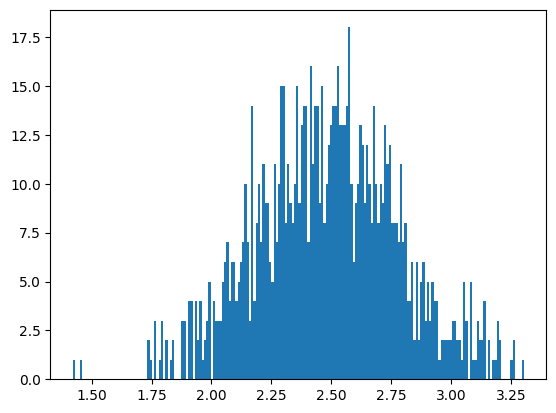



## MAX FLOP PER DOLLAR ##
{1: 19.966322252555738,
 5: 21.1053067260725,
 10: 21.574587939458038,
 20: 22.187517493791564,
 30: 22.646994108101698,
 40: 23.087476602740036,
 50: 23.520955129865037,
 60: 23.942263356960893,
 70: 24.3341185906204,
 80: 24.88107534559032,
 90: 25.491788325887295,
 95: 25.99240949776986,
 99: 26.987397079617665}


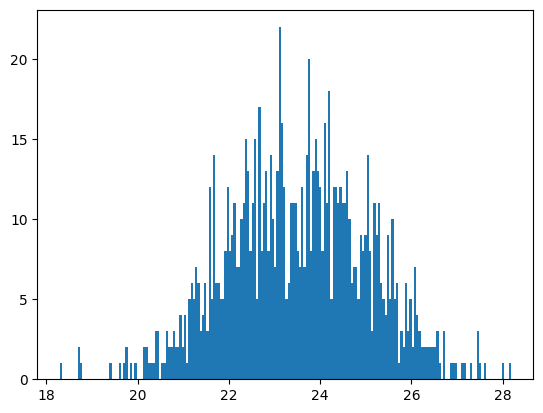



## INITIAL PAY ##
{1: 7.7,
 5: 8.0,
 10: 8.1,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.7,
 60: 8.8,
 70: 8.9,
 80: 9.1,
 90: 9.3,
 95: 9.6,
 99: 10.0}


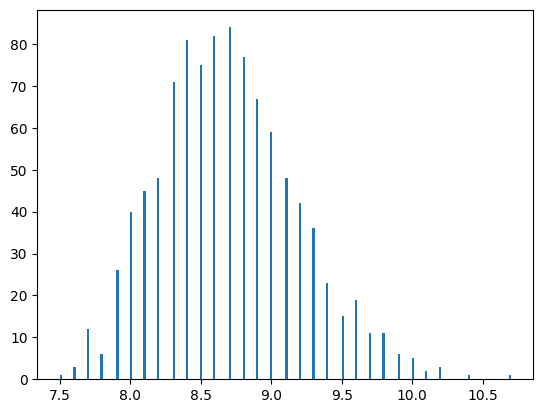



## INITIAL GDP ##
{1: 24797561971109.7,
 5: 24891733145417.684,
 10: 24933851753954.516,
 20: 24999945800136.895,
 30: 25039925250732.36,
 40: 25077812202322.086,
 50: 25110616544507.09,
 60: 25142336868400.465,
 70: 25177786238521.715,
 80: 25214898627224.746,
 90: 25263542854322.832,
 95: 25299363259569.793,
 99: 25405285526921.496}


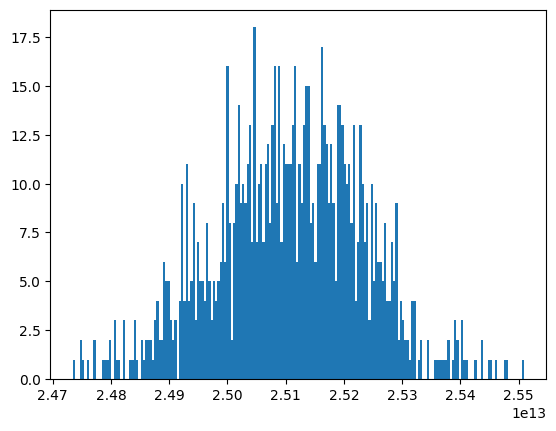



## GDP GROWTH ##
{1: 1.0059084568296788,
 5: 1.009473006331405,
 10: 1.0124635934615087,
 20: 1.0156243868073698,
 30: 1.0180711763859924,
 40: 1.0204257725302612,
 50: 1.0225262996793067,
 60: 1.0244676606385228,
 70: 1.0266079899065503,
 80: 1.028634484305931,
 90: 1.031684346294703,
 95: 1.034649171729985,
 99: 1.0398706606020955}


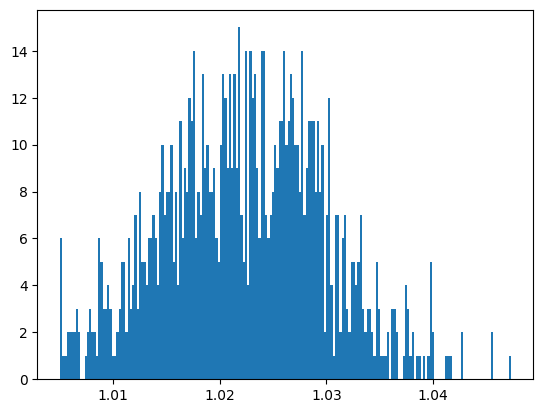



## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00025,
 60: 0.0003485473619441028,
 70: 0.0005044372865012056,
 80: 0.0007496612881340205,
 90: 0.0015700622870785297,
 95: 0.0027476428295377525,
 99: 0.005844492647206857}


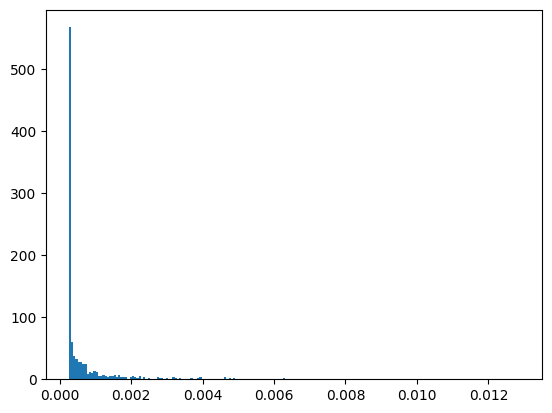



## SPEND DOUBLING TIME ##
{1: 0.9,
 5: 1.009505549680536,
 10: 1.2672872105265822,
 20: 1.631352366196674,
 30: 2.019638859293065,
 40: 2.451162404855147,
 50: 2.919585000531581,
 60: 3.384678512916047,
 70: 4.00543192610234,
 80: 4.9272424979495755,
 90: 6.509005523107046,
 95: 8.14301692065888,
 99: 12.210929355275749}


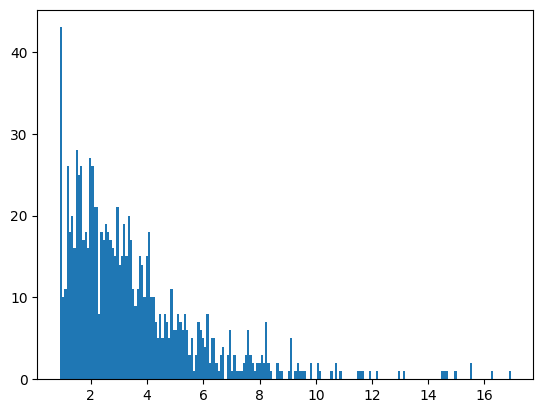





## Nonscaling delay ##
There are 7 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 2,
 5: 2,
 10: 2,
 20: 3,
 30: 3,
 40: 3,
 50: 3,
 60: 4,
 70: 4,
 80: 4,
 90: 5,
 95: 6,
 99: 13}
## Chance of nonscaling delay ##


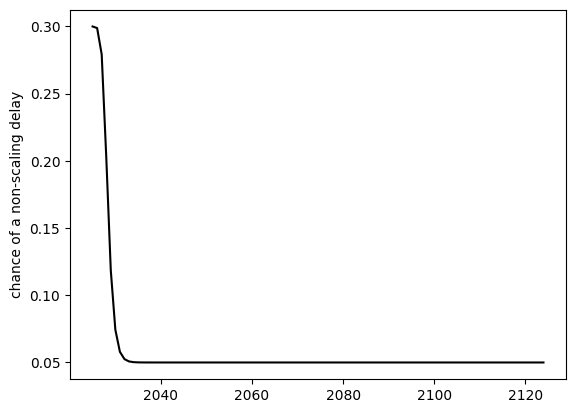

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - ch

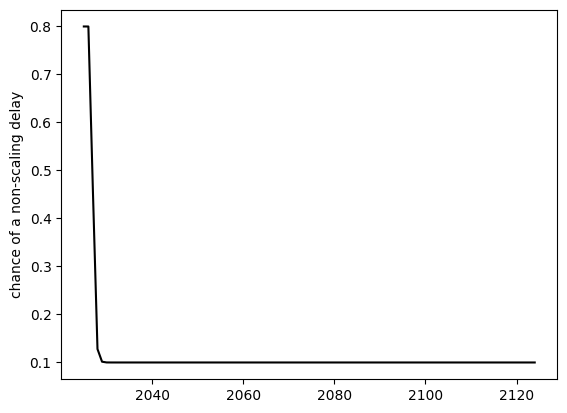

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

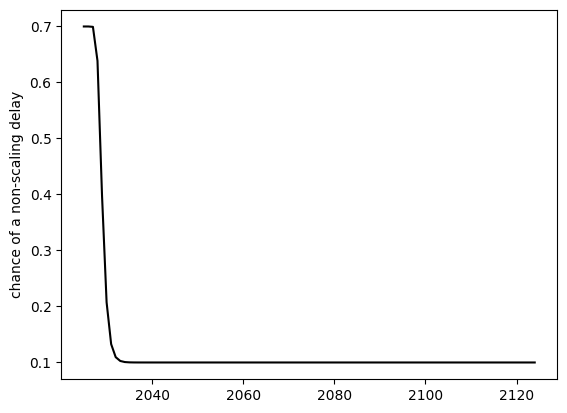

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

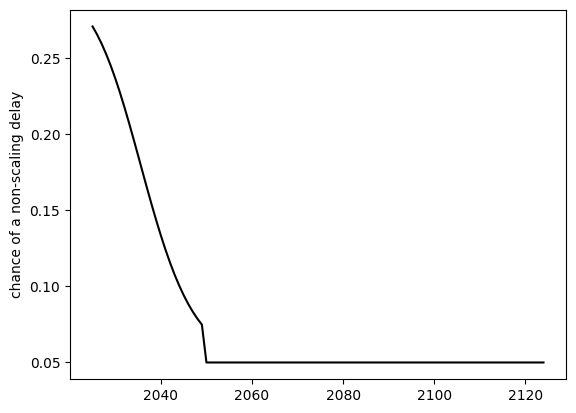

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2035

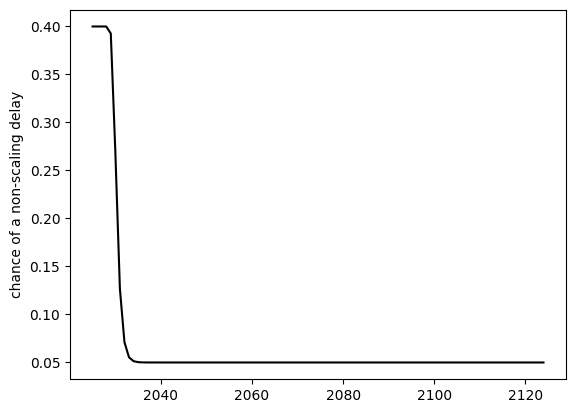

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - 

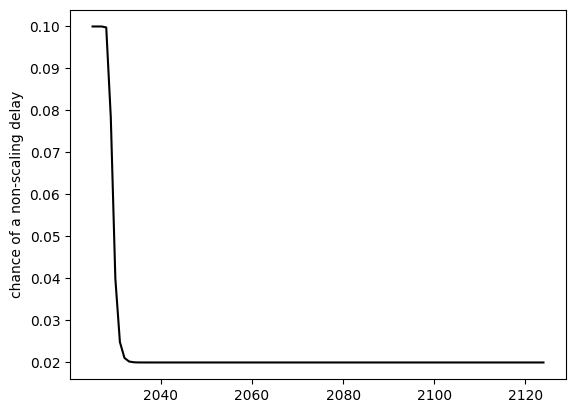

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 4%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2035 - cha

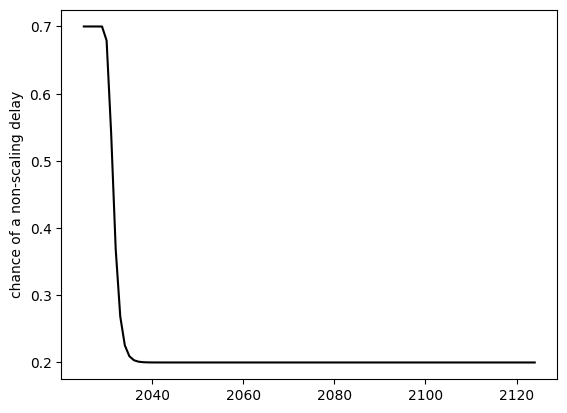

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 54%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2035

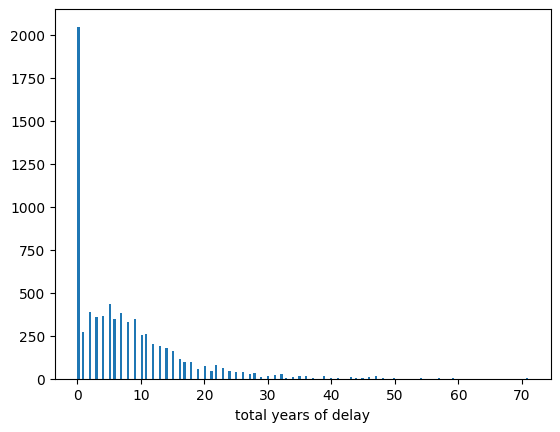

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 29.5 log FLOP (~316.2 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~161.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~4.3 billion).
* This doubles every 2.2 year to a max of 0.054153% of GDP (initially ~13.6 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 29.5 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 29.3 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 9.7 (buys 28.3 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 28.9 logFLOP which costs

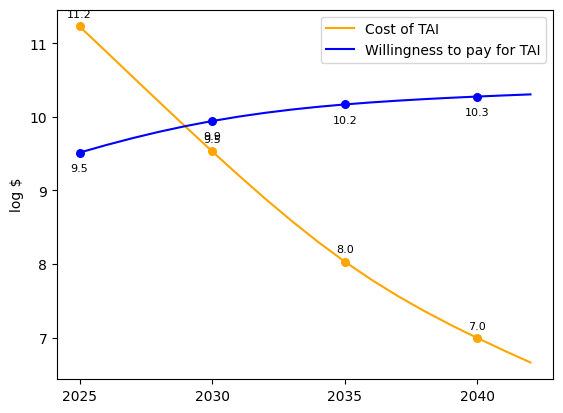

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 40.7 log FLOP (~50.1 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3.0 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~77.6 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.1 million).
* This doubles every 5.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 40.7 logFLOP which costs 22.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 40.3 logFLOP which costs 22.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 39.9 logFLOP which costs 21.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.2 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 39.5 logFLOP which

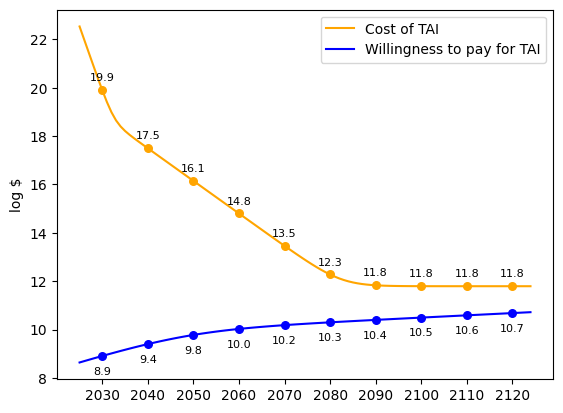

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.1 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~197.5 million).
* This doubles every 2.2 year to a max of 0.075418% of GDP (initially ~19.2 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.3 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 26.6 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 8.4 (buys 26.9 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (t

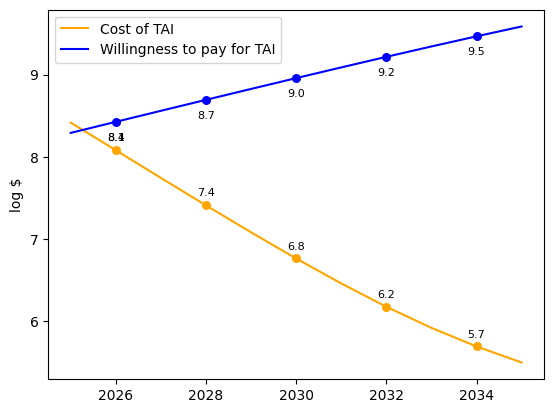

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 29.7 log FLOP (~501.2 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~237.9 septillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~125.5 million).
* This doubles every 1.1 year to a max of 0.1612% of GDP (initially ~40.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 29.7 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 8.1 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 29.5 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 29.3 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.6 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 29.1 logFLOP which costs

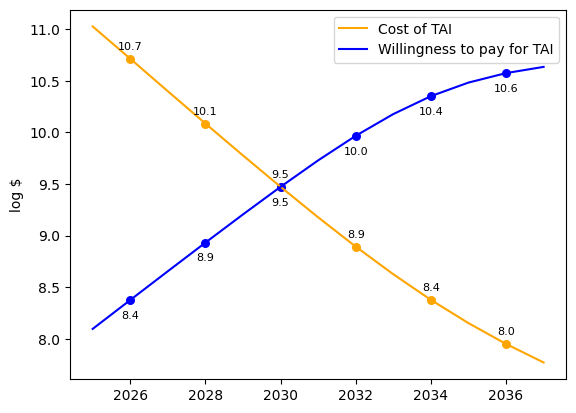

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 45.2 log FLOP (~1.6 trillion decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~53.8 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~195.8 million).
* This doubles every 3.3 year to a max of 0.04171% of GDP (initially ~10.5 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 45.2 logFLOP which costs 26.5 log 2025$USD to buy vs. WTP at 8.3 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 45.0 logFLOP which costs 26.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 44.8 logFLOP which costs 25.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 44.7 logFLOP whic

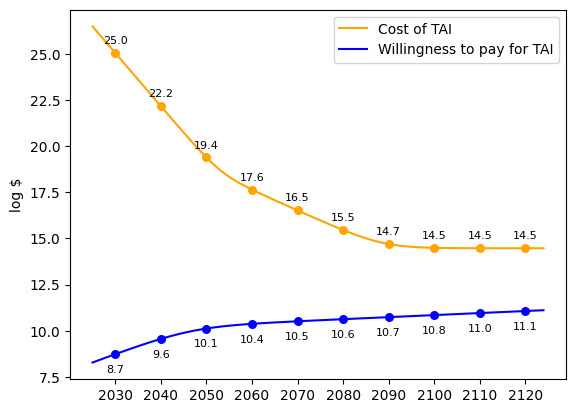

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~112.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 33.0 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 32.8 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.6 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 32.7 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 32.5 logFLOP which costs 1

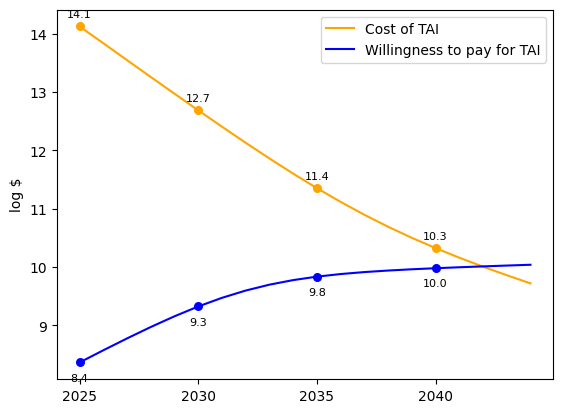

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~7.1 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~277.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.5 million).
* This doubles every 3.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occu

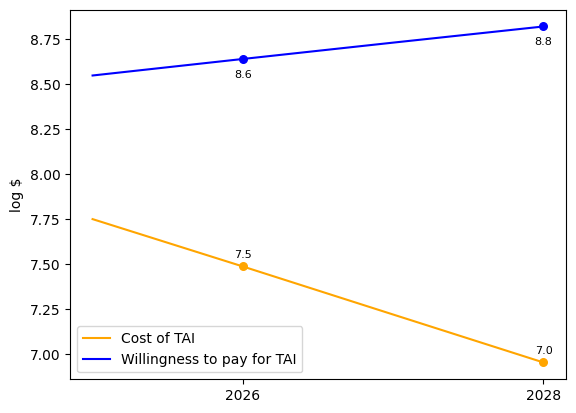

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~167.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~615.7 million).
* This doubles every 3.6 year to a max of 0.101861% of GDP (initially ~25.5 billion 2025$USD).
* GDP grows at a rate of 1.037x per year.
---
2025 - TAI takes 27.7 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 27.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (t

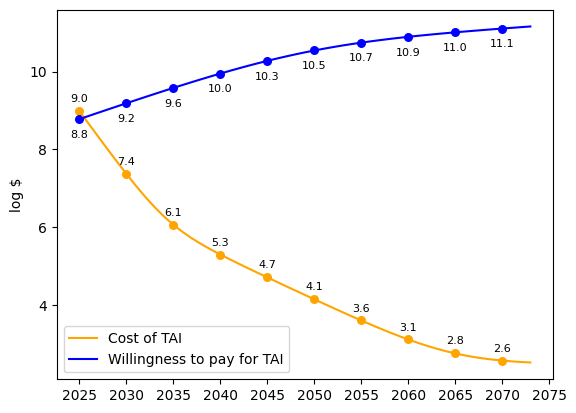

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 34.9 log FLOP (~79.4 decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2.2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.6 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.7 septillion) per 2025$USD.
* We are initially willing to pay 7.9 log 2025$USD (~78.4 million).
* This doubles every 6.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 34.9 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 7.9 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 34.7 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 7.9 (buys 26.8 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 34.6 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.0 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2028 - TAI takes 34.4 logFLOP which costs 15

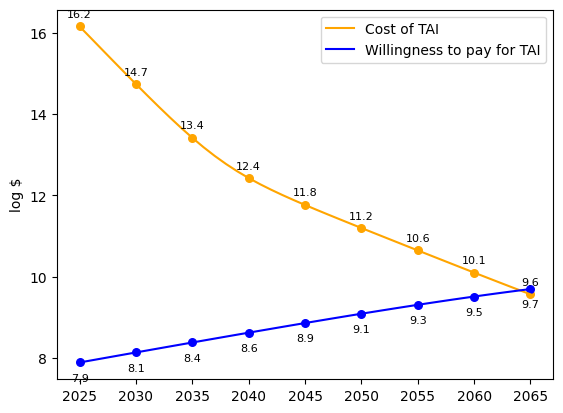

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 31.4 log FLOP (~25.1 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.1 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~56.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 7.1 year to a max of 0.259869% of GDP (initially ~64.8 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 31.4 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 31.0 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.3 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 30.5 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 30.1 logFLOP which costs 

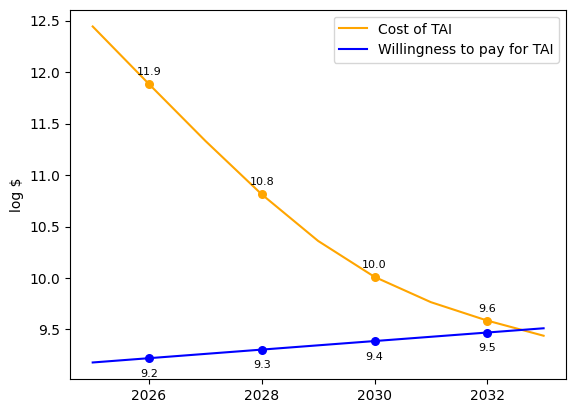

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 35.0 log FLOP (~100.0 decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~23.1 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~25.9 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~384.3 million).
* This doubles every 2.9 year to a max of 0.044641% of GDP (initially ~11.1 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 35.0 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 34.8 logFLOP which costs 15.3 log 2025$USD to buy vs. WTP at 8.7 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 34.6 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 8.8 (buys 28.4 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 34.5 logFLOP which co

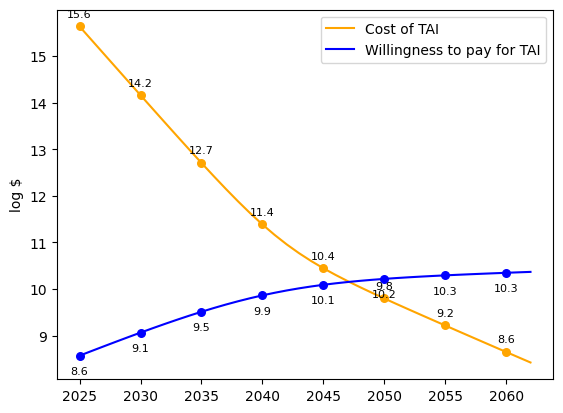

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 31.7 log FLOP (~50.1 nonillion) for transformative capabilities.
* Every 3.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~808.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 2.8 year to a max of 0.156959% of GDP (initially ~39.4 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 31.7 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 31.6 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 31.5 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 9.5 (buys 28.1 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 31.4 logFLOP which costs

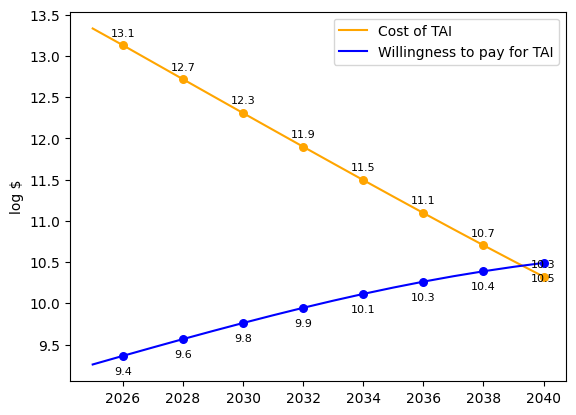

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 34.5 log FLOP (~31.6 decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2.8 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.8 billion).
* This doubles every 2.9 year to a max of 0.027779% of GDP (initially ~7.0 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 34.5 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 34.2 logFLOP which costs 15.4 log 2025$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 34.0 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 33.7 logFLOP which costs 

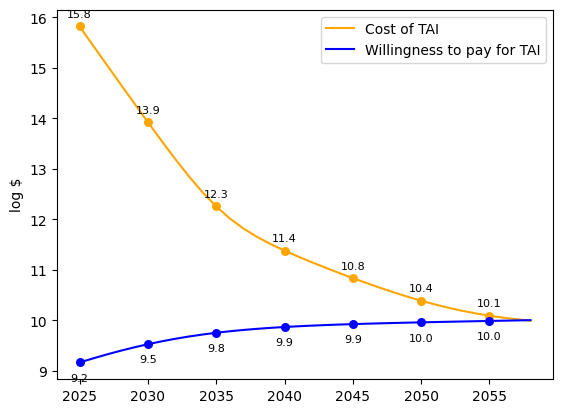

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 24.9 log FLOP (~7.9 septillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~963.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~123.4 million).
* This doubles every 1.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 24.9 logFLOP which costs 6.6 log 2025$USD to buy vs. WTP at 8.1 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)


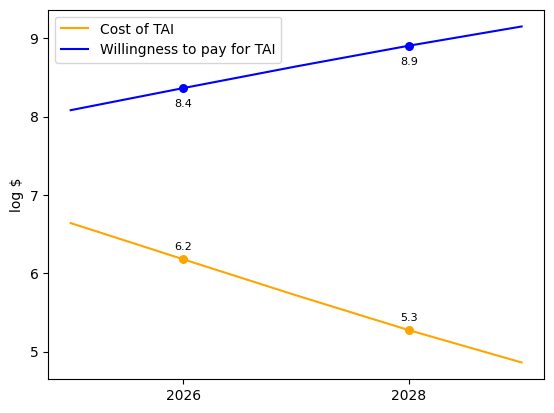

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 39.2 log FLOP (~1.6 million decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~125.4 million).
* This doubles every 1.9 year to a max of 0.116834% of GDP (initially ~29.5 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 39.2 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 8.1 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 39.0 logFLOP which costs 20.1 log 2025$USD to buy vs. WTP at 8.3 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 38.8 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 8.4 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 38.6 logFLOP whic

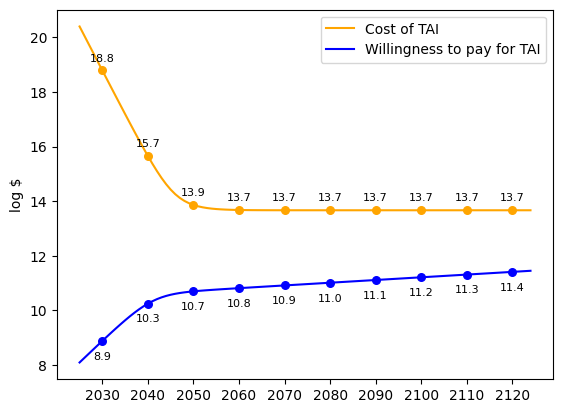

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 28.0 log FLOP (~10.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.2 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.3 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~380.1 million).
* This doubles every 2.7 year to a max of 0.03357% of GDP (initially ~8.4 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 28.0 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 27.8 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.8 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 27.6 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2793 -> No

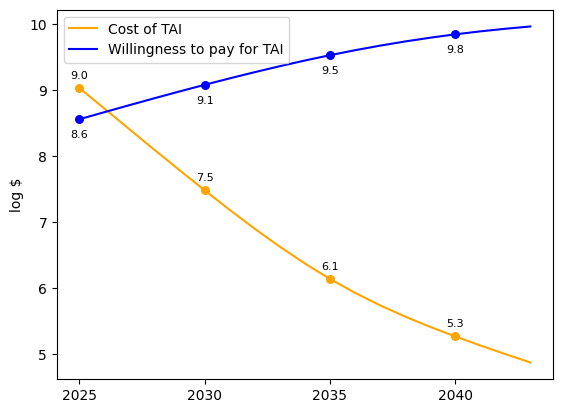

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 39.8 log FLOP (~6.3 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.9 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~5.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~193.4 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 39.8 logFLOP which costs 21.2 log 2025$USD to buy vs. WTP at 8.3 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 39.6 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 39.4 logFLOP which costs 20.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.6 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 39.2 logFLOP which cos

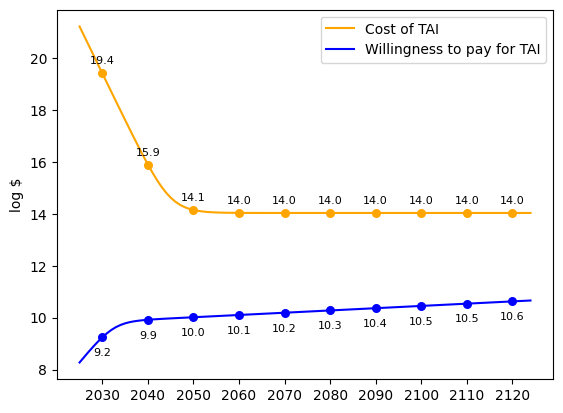

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 27.4 log FLOP (~2.5 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.2 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~542.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~245.3 million).
* This doubles every 2.6 year to a max of 0.041537% of GDP (initially ~10.4 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 27.4 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 

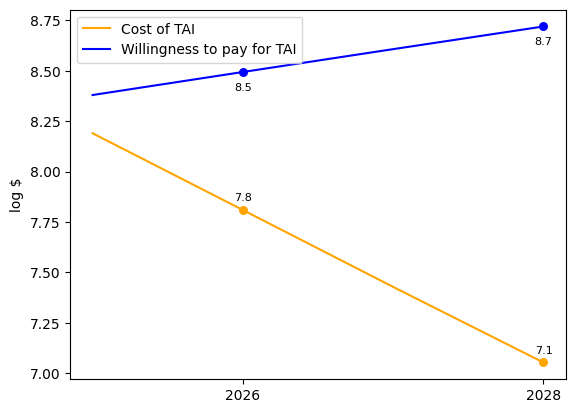

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~168.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.3 million).
* This doubles every 8.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 36.6 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 36.1 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.9 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 35.7 logFLOP whi

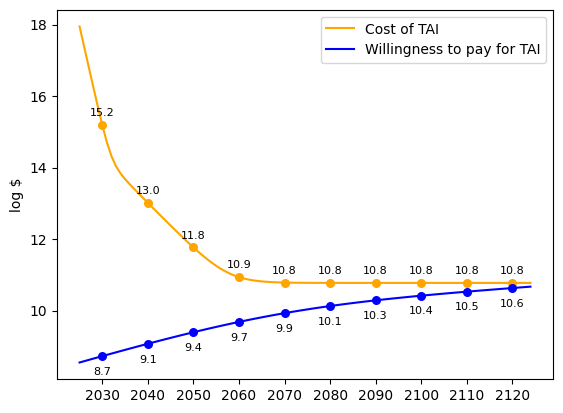

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 30.7 log FLOP (~5.0 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~593.8 million).
* This doubles every 3.0 year to a max of 0.040079% of GDP (initially ~10.1 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 30.7 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 30.4 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which costs 1

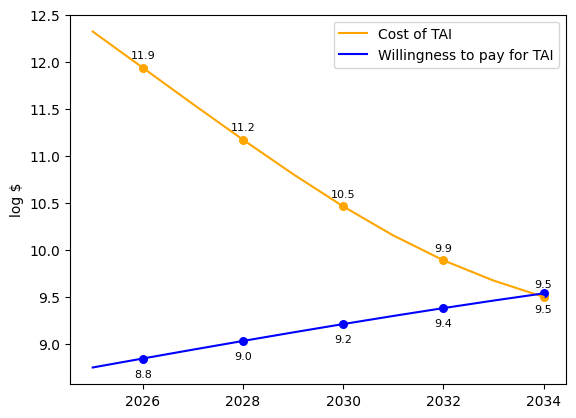

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 40.6 log FLOP (~39.8 million decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~21.4 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~76.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~755.0 million).
* This doubles every 4.5 year to a max of 0.060908% of GDP (initially ~15.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 40.6 logFLOP which costs 21.3 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 39.9 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 8.9 (buys 28.4 log FLOP or 29.1 2025-log-eFLOP)
2027 - TAI takes 39.3 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 9.0 (buys 28.6 log FLOP or 30.0 2025-log-eFLOP)
2028 - TAI takes 38.6 logFLOP wh

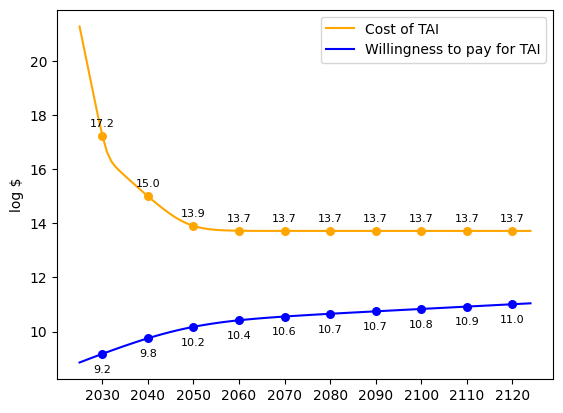

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
* Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.7 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~705.4 million).
* This doubles every 3.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 32.8 logFLOP which costs 14.8 log 2025$USD to buy vs. WTP at 8.8 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 32.7 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 32.6 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2028 - TAI takes 32.5 logFLOP which costs 14

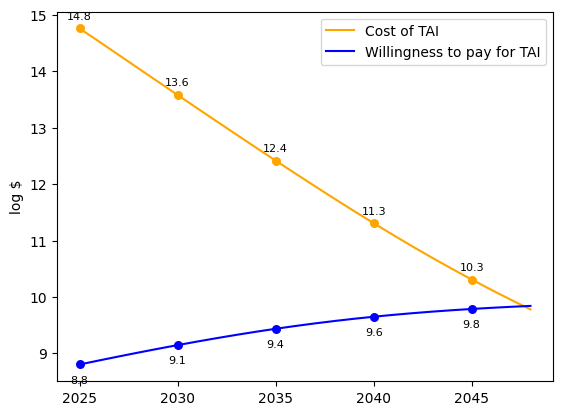

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 37.8 log FLOP (~63.1 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2.3 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.2 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.5 septillion) per 2025$USD.
* We are initially willing to pay 8.0 log 2025$USD (~98.4 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 37.8 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.0 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 37.5 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 8.3 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 37.2 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 37.0 logFLOP which

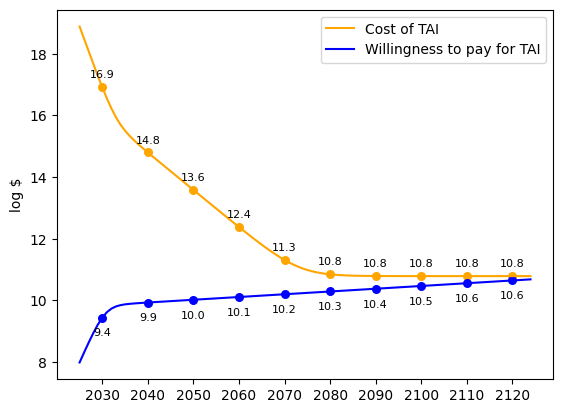

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 42.2 log FLOP (~1.6 billion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~12.2 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~396.0 million).
* This doubles every 10.1 year to a max of 0.302529% of GDP (initially ~75.9 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 42.2 logFLOP which costs 23.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 41.9 logFLOP which costs 23.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 41.7 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 41.4 logFLOP wh

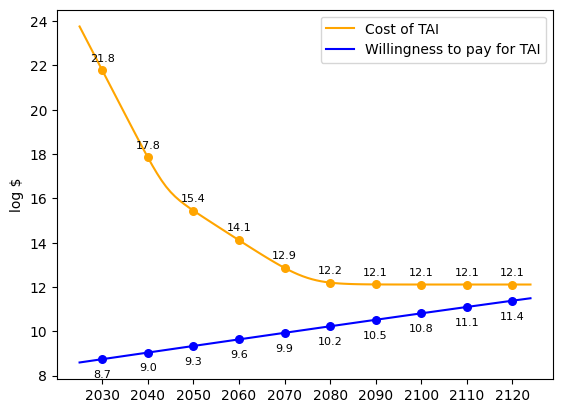

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 25.1 log FLOP (~12.6 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.4 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.7 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~158.3 million).
* This doubles every 5.6 year to a max of 0.4652% of GDP (initially ~117.0 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 25.1 logFLOP which costs 6.0 log 2025$USD to buy vs. WTP at 8.2 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 -

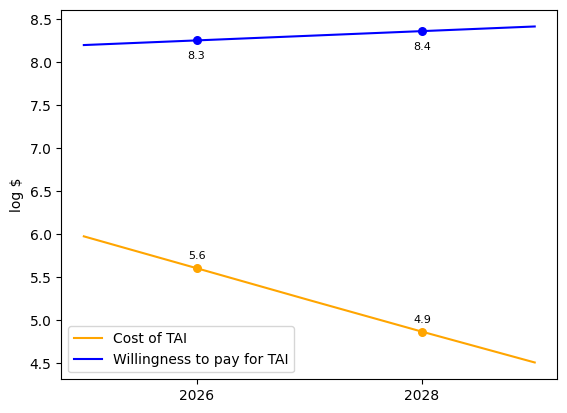

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 31.0 log FLOP (~10.0 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~21.4 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.5 septillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.6 billion).
* This doubles every 0.9 year to a max of 0.1484% of GDP (initially ~37.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 31.0 logFLOP which costs 11.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.8 log FLOP or 28.8 2025-log-eFLOP)
2026 - TAI takes 30.6 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 9.8 (buys 29.2 log FLOP or 29.7 2025-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 10.1 (buys 29.6 log FLOP or 30.5 2025-log-eFLOP)
2028 - TAI takes 29.7 logFLOP which costs 1

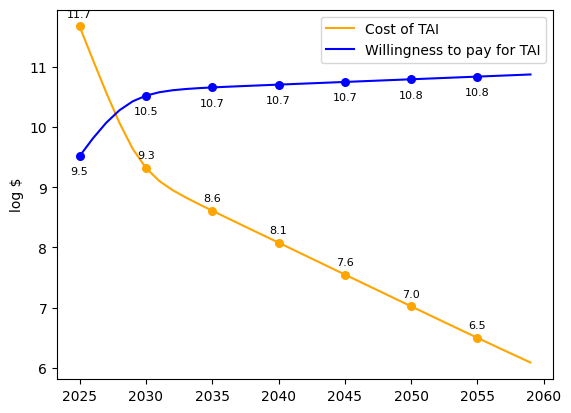

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 30.2 log FLOP (~1.6 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.5 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~12.5 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 2.7 year to a max of 0.099356% of GDP (initially ~24.9 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 30.2 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 30.0 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 29.8 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 29.6 logFLOP which costs 1

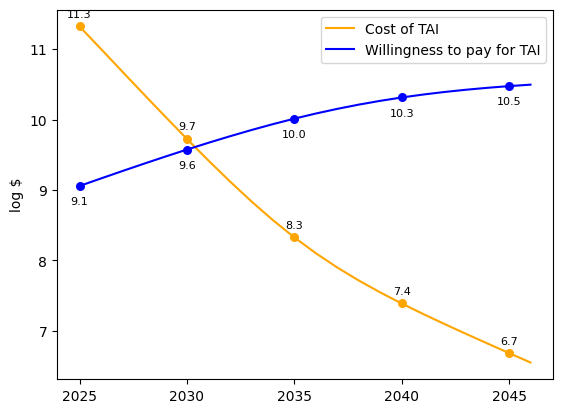

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 49.9 log FLOP (~79.4 quadrillion decillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~19.3 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~556.8 sextillion) per 2025$USD.
* We are initially willing to pay 7.9 log 2025$USD (~78.4 million).
* This doubles every 5.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.01x per year.
---
2025 - TAI takes 49.9 logFLOP which costs 30.6 log 2025$USD to buy vs. WTP at 7.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 49.7 logFLOP which costs 30.4 log 2025$USD to buy vs. WTP at 7.9 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 49.6 logFLOP which costs 30.1 log 2025$USD to buy vs. WTP at 8.0 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 49.4 logFLOP wh

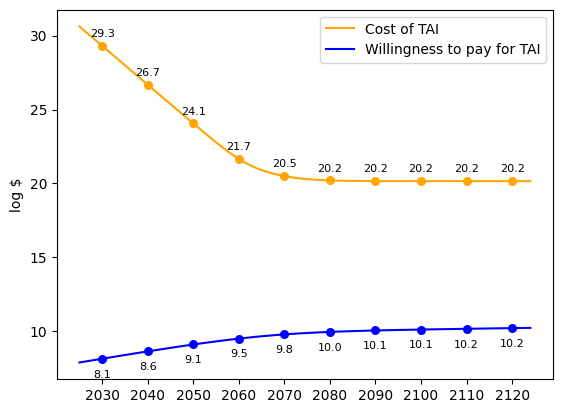

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 35.0 log FLOP (~100.0 decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~2.9 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~863.2 million).
* This doubles every 8.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 35.0 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 34.3 logFLOP which costs 15.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 33.6 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 32.9 logFLOP which costs 13

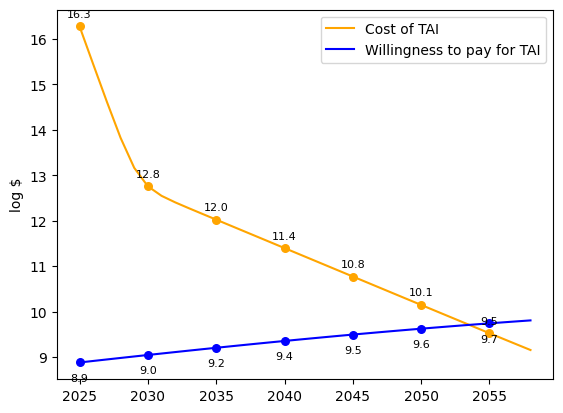

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 39.3 log FLOP (~2.0 million decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.4 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~163.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.4 billion).
* This doubles every 0.9 year to a max of 0.045895% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 39.3 logFLOP which costs 20.3 log 2025$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 39.0 logFLOP which costs 19.9 log 2025$USD to buy vs. WTP at 9.4 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 38.8 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 9.6 (buys 28.9 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 38.5 logFLOP whi

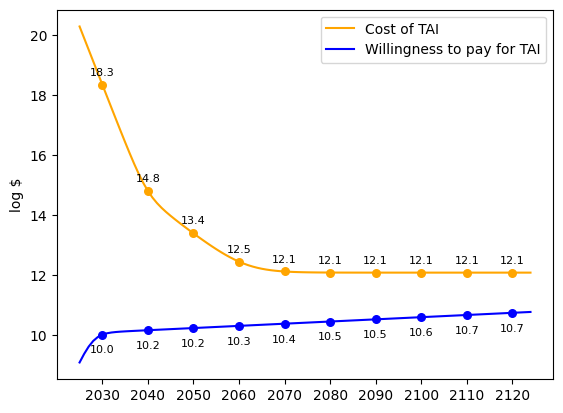

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 35.5 log FLOP (~316.2 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~217.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.6 million).
* This doubles every 6.0 year to a max of 0.026028% of GDP (initially ~6.5 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 35.5 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 8.5 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 35.3 logFLOP which costs 16.7 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 35.1 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 34.9 logFLOP which cos

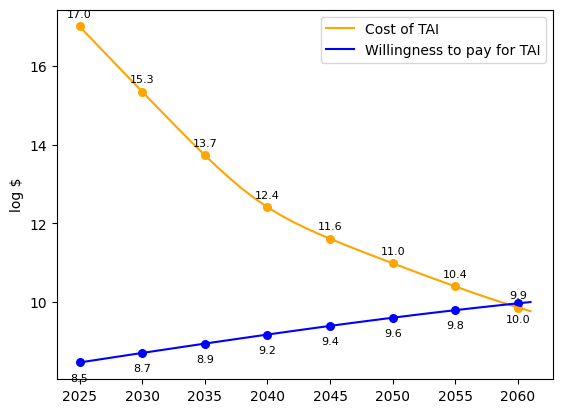

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~76.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.041x per year.
---
2025 - TAI takes 27.7 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 8.2 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 27.6 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.3 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 27.5 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 27.3 logFLOP which costs 8.4 lo

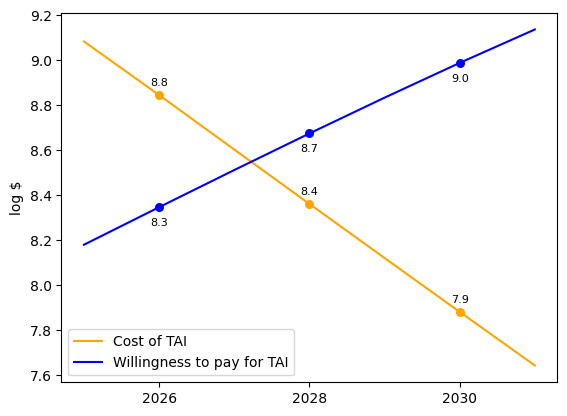

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.8 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 4.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 5 years)
--

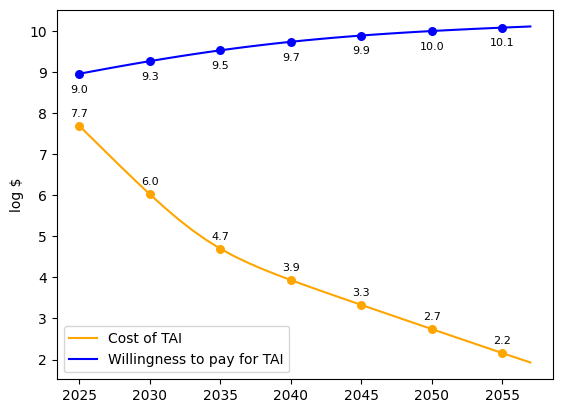

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 32.0 log FLOP (~100.0 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~112.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 2.3 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.007x per year.
---
2025 - TAI takes 32.0 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 31.8 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.5 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 31.3 logFLOP which costs 12

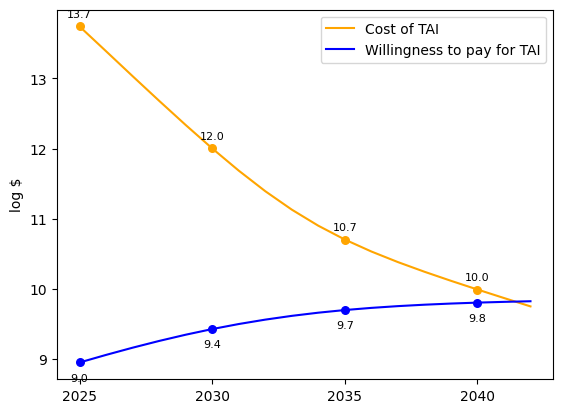

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 31.6 log FLOP (~39.8 nonillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9.8 septillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~123.4 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 31.6 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 8.1 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 31.5 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 8.4 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 8.7 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 31.2 logFLOP which costs 11

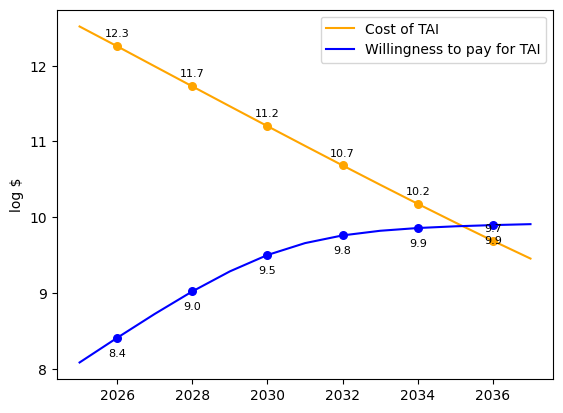

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 6.3 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 8.2 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 26.5 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 8.2 (buys 26.8 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (tota

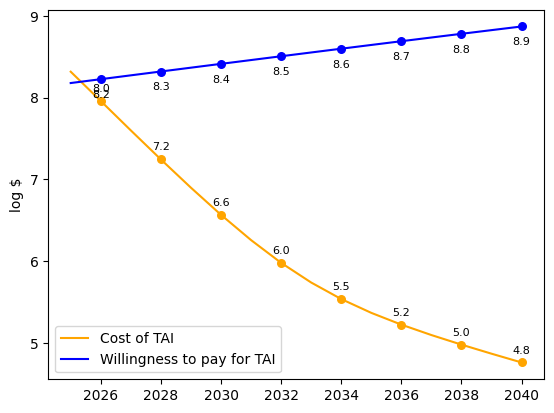

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 41.4 log FLOP (~251.2 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.2 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.0 million).
* This doubles every 2.9 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 41.4 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 8.5 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 41.0 logFLOP which costs 22.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 40.6 logFLOP which costs 21.8 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 40.1 logFLOP which 

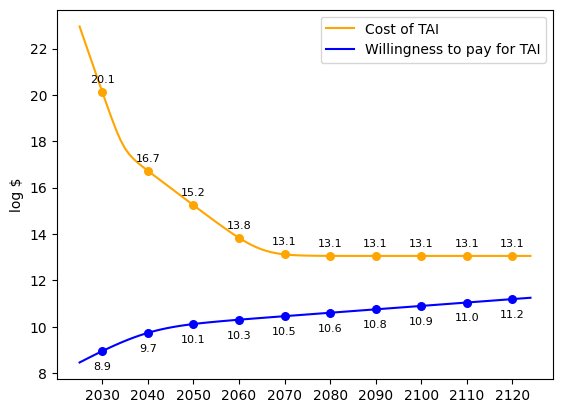

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~21.1 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.1 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~193.4 million).
* This doubles every 13.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.008x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 7.3 log 2025$USD to buy vs. WTP at 8.3 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occu

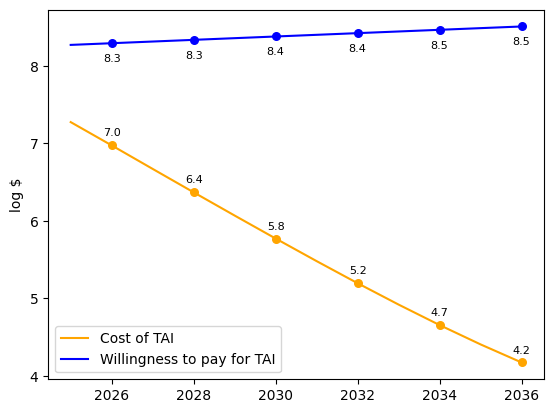

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 43.1 log FLOP (~12.6 billion decillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.5 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.0 septillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~5.5 billion).
* This doubles every 9.6 year to a max of 0.048456% of GDP (initially ~12.2 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 43.1 logFLOP which costs 24.4 log 2025$USD to buy vs. WTP at 9.6 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 43.0 logFLOP which costs 24.2 log 2025$USD to buy vs. WTP at 9.6 (buys 28.4 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 42.8 logFLOP which costs 23.9 log 2025$USD to buy vs. WTP at 9.6 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 42.7 logFLOP which

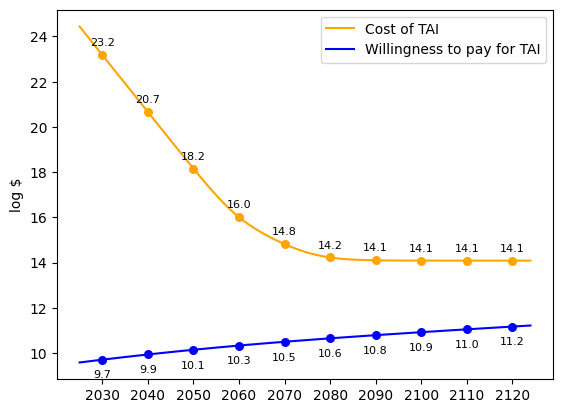

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 42.1 log FLOP (~1.3 billion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.4 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.9 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~302.8 million).
* This doubles every 4.6 year to a max of 0.028147% of GDP (initially ~7.1 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 42.1 logFLOP which costs 23.2 log 2025$USD to buy vs. WTP at 8.5 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 41.8 logFLOP which costs 22.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 41.6 logFLOP which costs 22.5 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 41.3 logFLOP which

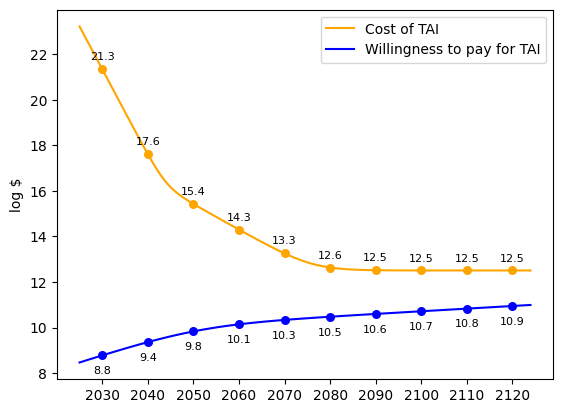

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~992.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~315.8 million).
* This doubles every 3.3 year to a max of 0.867164% of GDP (initially ~217.0 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 33.3 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 33.0 logFLOP which co

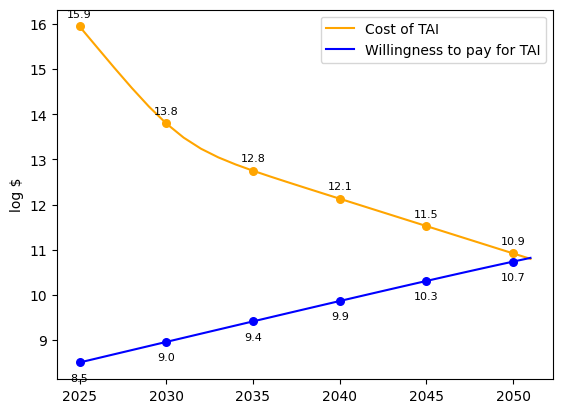

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 42.0 log FLOP (~1.0 billion decillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.0 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~107.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~970.3 million).
* This doubles every 4.4 year to a max of 0.130313% of GDP (initially ~32.7 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 42.0 logFLOP which costs 23.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 41.9 logFLOP which costs 22.8 log 2025$USD to buy vs. WTP at 9.0 (buys 28.1 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 41.7 logFLOP which costs 22.6 log 2025$USD to buy vs. WTP at 9.1 (buys 28.2 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 41.6 logFLOP wh

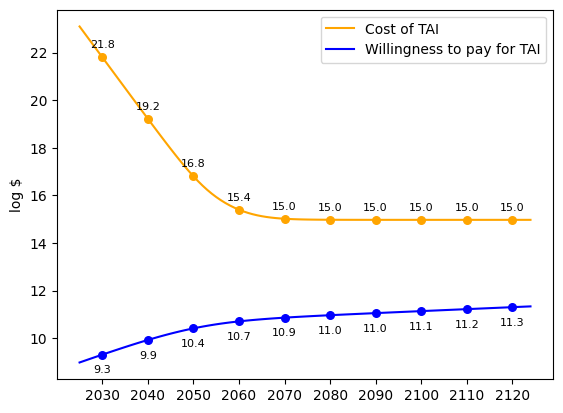

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.4 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~157.3 million).
* This doubles every 2.3 year to a max of 0.083823% of GDP (initially ~21.2 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 8.2 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 7 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- 

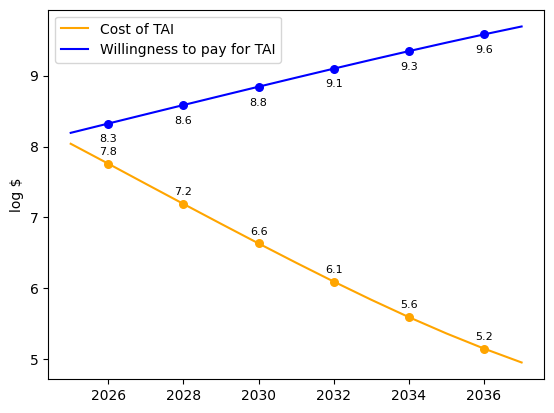

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 36.0 log FLOP (~1.0 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~28.6 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~4.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 4.2 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 36.0 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.4 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 35.7 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 8.4 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 35.5 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 8.5 (buys 28.2 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 35.2 logFLOP which 

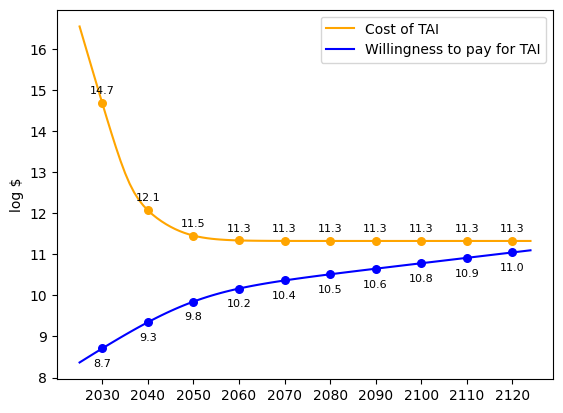

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 25.6 log FLOP (~39.8 septillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.6 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~14.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.4 billion).
* This doubles every 2.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 25.6 logFLOP which costs 6.8 log 2025$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 -> Nons

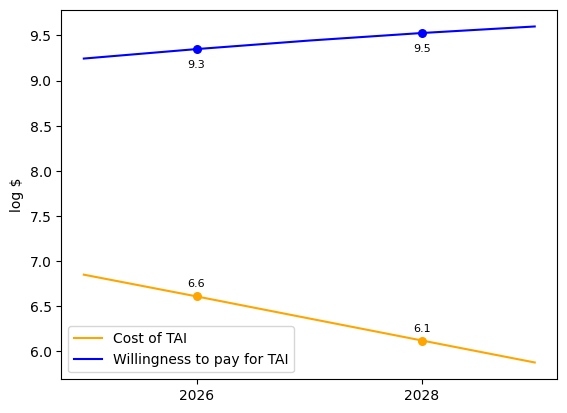

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 36.3 log FLOP (~2.0 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~224.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~389.1 million).
* This doubles every 5.3 year to a max of 0.068351% of GDP (initially ~17.2 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 36.3 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 36.0 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 35.7 logFLOP which costs 16.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 35.3 logFLOP w

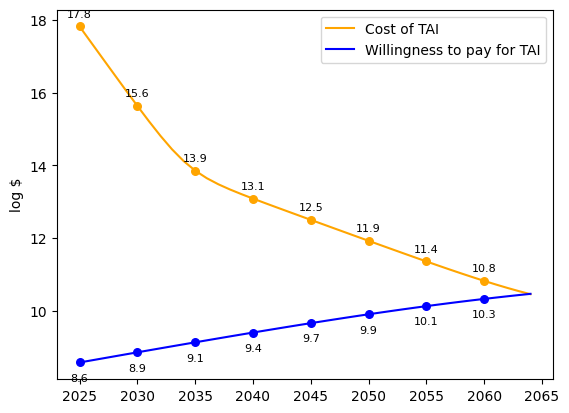

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 28.2 log FLOP (~15.8 octillion) for transformative capabilities.
* Every 3.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.7 log FLOP (~54.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~100.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.6 billion).
* This doubles every 6.8 year to a max of 0.02577% of GDP (initially ~6.4 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 28.2 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 9.4 (buys 29.1 log FLOP or 29.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 years)

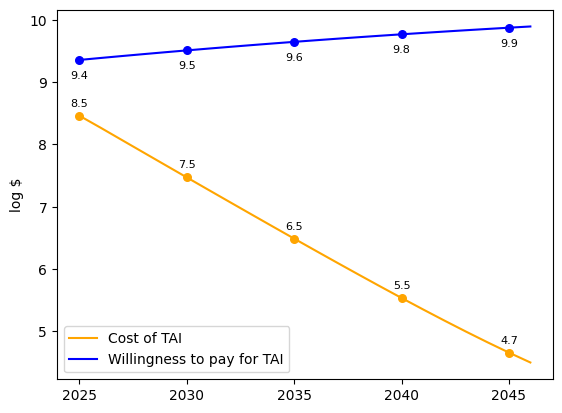

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 30.8 log FLOP (~6.3 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~95.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~389.8 million).
* This doubles every 11.9 year to a max of 0.073456% of GDP (initially ~18.6 billion 2025$USD).
* GDP grows at a rate of 1.01x per year.
---
2025 - TAI takes 30.8 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 30.6 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 30.3 logFLOP which costs 11.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 30.1 logFLOP which costs

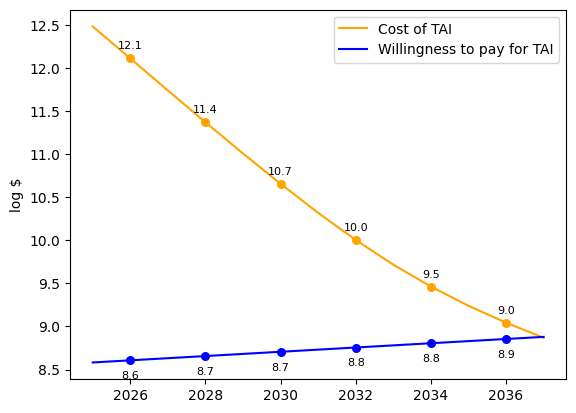

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~130.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 8.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.038x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 -> Nons

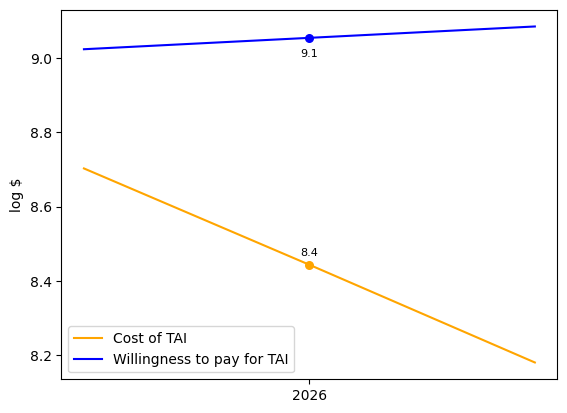

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.5 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.6 septillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~123.4 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 8.1 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 6 years)
--

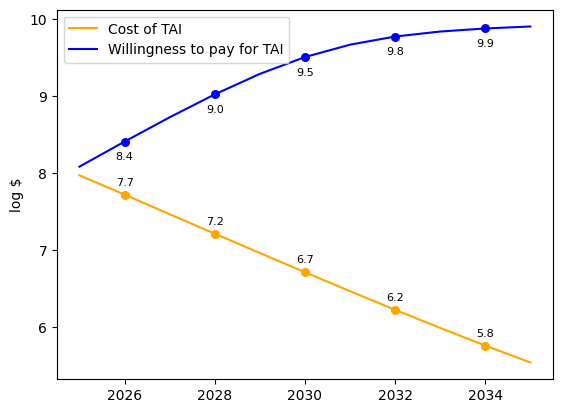

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-03-27 14:17:04.667487
